In [23]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import BorderlineSMOTE
from geopy.distance import geodesic
import seaborn as sns
from math import fabs
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings("ignore")

In [24]:
#loading the combined texas roadhouse and census data
df = pd.read_csv("trhCensusDf_updated.csv")

In [25]:
df.describe()

,rating,totalUserRatings,latitude,longitude,ZIP,stateFIPS,placeFIPS,totalPopulation,malePopulation,femalePopulation,...,carAvailability,disabilityPopulation,healthInsurancePopulation,householdPopulation,singleParentHouseholds,marriedPopulation,state_y,place,successMetric,nearestDistanceToTRH
count,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,5.970000e+02,5.970000e+02,5.970000e+02,...,597.000000,5.970000e+02,5.970000e+02,597.000000,597.000000,5.970000e+02,597.000000,597.000000,597.000000,597.000000
mean,4.351591,3590.132328,37.223995,-89.811102,50224.825796,29.180905,42552.738693,1.350500e+05,6.629871e+04,6.875125e+04,...,51095.517588,1.330023e+05,1.330023e+05,51095.517588,30498.752094,1.087663e+05,29.180905,42552.738693,15712.980067,27.200148
std,0.140176,1701.688767,4.830041,12.220468,24817.103506,15.953080,23720.722136,2.495405e+05,1.233435e+05,1.262292e+05,...,90975.265588,2.469647e+05,2.469647e+05,90975.265588,54889.989132,1.983996e+05,15.953080,23720.722136,7560.577483,26.517130
min,3.500000,3.000000,25.459587,-123.103621,1128.000000,1.000000,160.000000,1.100000e+02,4.600000e+01,6.400000e+01,...,36.000000,1.100000e+02,1.100000e+02,36.000000,20.000000,8.700000e+01,1.000000,160.000000,11.100000,0.000000
25%,4.300000,2505.000000,33.578662,-96.556531,31322.000000,16.000000,22502.000000,2.773000e+04,1.333200e+04,1.420300e+04,...,10805.000000,2.720700e+04,2.720700e+04,10805.000000,6281.000000,2.272200e+04,16.000000,22502.000000,10819.600000,10.892056
50%,4.400000,3730.000000,38.439425,-86.339607,46706.000000,29.000000,42032.000000,5.731800e+04,2.767700e+04,2.887100e+04,...,21871.000000,5.555400e+04,5.555400e+04,21871.000000,13044.000000,4.619800e+04,29.000000,42032.000000,16183.200000,17.913990
75%,4.400000,4754.000000,40.750194,-81.296314,75028.000000,44.000000,61892.000000,1.174880e+05,5.727800e+04,6.037000e+04,...,46586.000000,1.155190e+05,1.155190e+05,46586.000000,27506.000000,9.486100e+04,44.000000,61892.000000,20916.000000,32.677558
max,4.600000,9127.000000,48.798766,-68.756095,99336.000000,56.000000,88240.000000,2.313238e+06,1.152063e+06,1.161175e+06,...,874827.000000,2.296993e+06,2.296993e+06,874827.000000,526874.000000,1.829104e+06,56.000000,88240.000000,41071.500000,186.427104


In [26]:
#computing a success metric, performing feature engineering and placing income in bins for easier analysis.
m = 50
C = df['rating'].mean()
df['successMetric'] = (df['totalUserRatings'] * df['rating'] + m * C) / (df['totalUserRatings'] + m)
threshold = np.percentile(df['successMetric'], 75)
df['success'] = np.where(df['successMetric'] > threshold, 1, 0)
df['incomeRentRatio'] = df['medianHouseholdIncome'] / (df['medianGrossRent'] + 1e-6)
df['povertyRatio'] = df['populationBelowPoverty'] / (df['totalPopulation'] + 1e-6)
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df['incomeBins'] = binner.fit_transform(df[['medianHouseholdIncome']])
#df['populationPenalty'] = 1 / (df['totalPopulation'] + 1e-6)
df['employmentRate'] = df['employedPopulation'] / (df['totalPopulation'] + 1e-6)
#df['spendingPotential'] = df['medianHouseholdIncome'] * (1 - df['povertyRatio'])
distanceWeight = 15
popWeight = 10
df['distancePenalty'] = df['nearestDistanceToTRH'].apply(lambda dist: 1 if 10 <= dist <= 50 else (10 / dist if dist > 50 else dist / 10))
df['weightedDistancePenalty'] = df['distancePenalty'] * distanceWeight
df['populationPenalty'] = 1 / (df['totalPopulation'] + 1e-6)
df['weightedPopulationPenalty'] = df['populationPenalty'] * popWeight

In [27]:
#dropping the state columns
df = df.drop(['state_x', 'state_y'], axis=1)

In [28]:
#defining features relevant to our analysis (xSimp and x) and the target variable (y)
relevantFeatures = ['totalPopulation', 'malePopulation', 'femalePopulation', 'medianAge', 'medianAgeMale', 'medianAgeFemale', 'whitePopulation', 'blackPopulation', 'asianPopulation',
                    'hispanicPopulation', 'medianHouseholdIncome', 'perCapitaIncome', 'populationBelowPoverty', 'medianGrossRent', 'incomeBelow10k', 'income10kTo15k', 'income15kTo25k',
                    'totalHousingUnits', 'ownerOccupiedHousingUnits', 'renterOccupiedHousingUnits', 'medianHomeValue', 'medianMonthlyHousingCosts', 'medianYearStructureBuilt',
                    'totalEducationPopulation', 'bachelorsDegree', 'mastersDegree', 'doctorateDegree', 'employedPopulation', 'occupationData',
                    'foreignBornPopulation', 'notHispanicWhitePopulation', 'notHispanicBlackPopulation', 'commuters', 'meanTravelTime', 'carAvailability', 'disabilityPopulation',
                    'healthInsurancePopulation', 'householdPopulation', 'singleParentHouseholds', 'marriedPopulation',  'incomeRentRatio', 'povertyRatio', 'incomeBins', 'weightedPopulationPenalty',
                    'employmentRate', 'managementOccupation', 'serviceOccupation'] #'managementOccupation', 'serviceOccupation',
#defining xSimp for logistic regression model and x for gradient boosting model.
xSimp = df[relevantFeatures]
x = df.drop(columns=['name', 'address', 'city', 'placeName', 'successMetric', 'success', 'rating', 'totalUserRatings', 'placeID']) #, 'managementOccupation', 'serviceOccupation', 'ZIP'
y = df['success']

In [29]:
#calculating vif to identify and drop features where vif is greater than 10, as this signals high multicolinearity
vifData = pd.DataFrame()
vifData['feature'] = xSimp.columns
vifData['vif'] = [variance_inflation_factor(xSimp.values, i) for i in range(xSimp.shape[1])]
xSimpHighVIF = vifData[vifData['vif'] > 10]['feature'].tolist()
xSimp = xSimp.drop(columns=xSimpHighVIF)

In [30]:
#dropping the geometry column from x
x = x.drop(['geometry'], axis=1)

In [31]:
#preparing xSimp for logistic regression by encoding varibles and normalizing data.
xSimp = pd.get_dummies(xSimp, drop_first=True)
x = pd.get_dummies(x, drop_first=True)
xSimp = xSimp.apply(lambda col: (col - col.mean()) / col.std())

In [32]:
#removing columns where all rows have the same value.
for df in [xSimp, x]:
    constantColumns = [col for col in df.columns if df[col].nunique() == 1]
    if constantColumns:
        df.drop(columns=constantColumns, inplace=True)

In [33]:
#defining smote.
smote = BorderlineSMOTE(random_state=42, k_neighbors=2)

In [34]:
#conducting train test splits for both the logistic regression and gradient boosting models
xSimpBalanced, yBalanced = smote.fit_resample(xSimp, y)
xBalanced, yBalanced = smote.fit_resample(x, y)
xTrainSimp, xTestSimp, yTrain, yTest = train_test_split(xSimpBalanced, yBalanced, test_size=0.3, random_state=42)
xTrain, xTest, yTrain, yTest = train_test_split(xBalanced, yBalanced, test_size=0.3, random_state=42)

In [35]:
#training logistic regression baseline
logReg = LogisticRegression(max_iter=1000, random_state=38)
logReg.fit(xTrainSimp, yTrain)
yPredLogReg = logReg.predict(xTestSimp)

In [36]:
#training a fine-tuned gradient boosting model.
tunedGradBoost = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=200, random_state=38)
tunedGradBoost.fit(xTrain, yTrain)
yPredTunedGradBoost = tunedGradBoost.predict(xTest)

In [37]:
#performing cross validation on the gradient boosting model and print the average f1 score.
stratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
crossValF1 = cross_val_score(tunedGradBoost, xTrain, yTrain, cv=stratifiedKFold, scoring='f1_weighted')

In [38]:
#printing metrics for logReg, gb, and cross val.
print(f"LOGISTIC REGRESSION BASE LINE MODEL: Accuracy: {accuracy_score(yTest, yPredLogReg):.4f}, Precision: {precision_score(yTest, yPredLogReg):.4f}, Recall: {recall_score(yTest, yPredLogReg):.4f}, F1 Score: {f1_score(yTest, yPredLogReg):.4f}")
print(f"GRADIENT BOOSTING FINE-TUNED MODEL : Accuracy: {accuracy_score(yTest, yPredTunedGradBoost):.4f}, Precision: {precision_score(yTest, yPredTunedGradBoost):.4f}, Recall: {recall_score(yTest, yPredTunedGradBoost):.4f}, F1 Score: {f1_score(yTest, yPredTunedGradBoost):.4f}")
print(f"CROSS VALIDATION MAE FOR EACH FOLD : {[f'{mae:.4f}' for mae in crossValF1]}")
print(f"AVERAGE CROSS VAL MAE FOR ALL FOLDS: {np.mean(crossValF1):.4f}")

LOGISTIC REGRESSION BASE LINE MODEL: Accuracy: 0.4758, Precision: 0.4758, Recall: 1.0000, F1 Score: 0.6448
GRADIENT BOOSTING FINE-TUNED MODEL : Accuracy: 0.8476, Precision: 0.8271, Recall: 0.8594, F1 Score: 0.8429
CROSS VALIDATION MAE FOR EACH FOLD : ['0.8333', '0.8173', '0.8640', '0.8000', '0.8397']
AVERAGE CROSS VAL MAE FOR ALL FOLDS: 0.8309


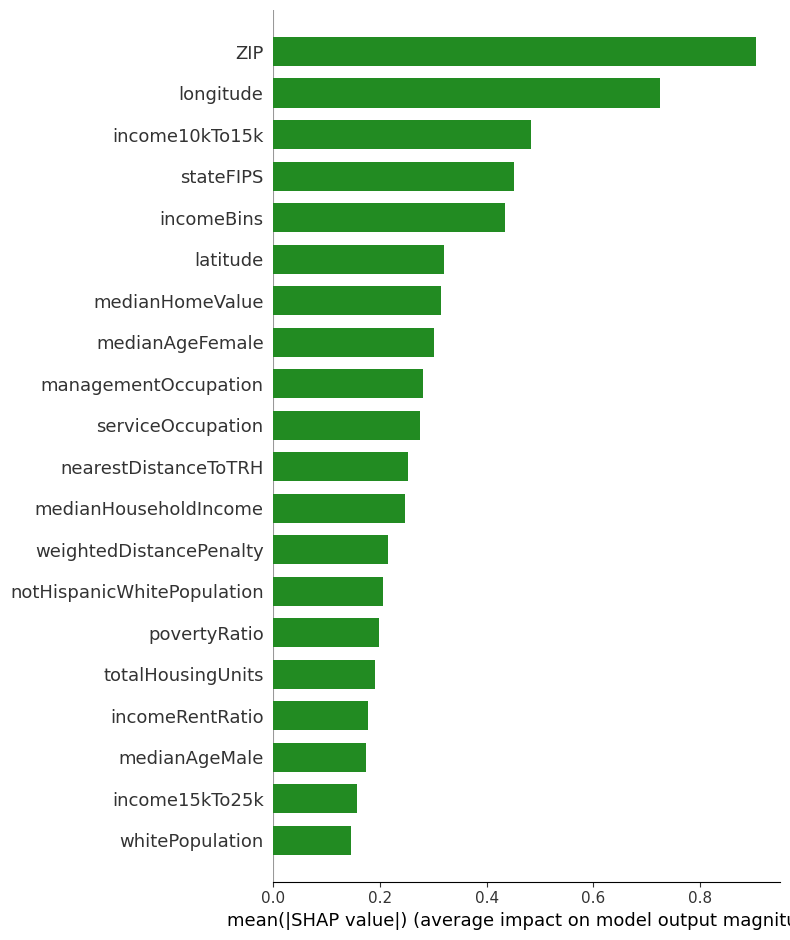

In [39]:
#performing SHAP analysis to understand which features contributed most to the predictions
explainer = shap.TreeExplainer(tunedGradBoost)
shapValues = explainer.shap_values(xTest)
shap.summary_plot(shapValues, xTest, plot_type="bar", color='#228B22')

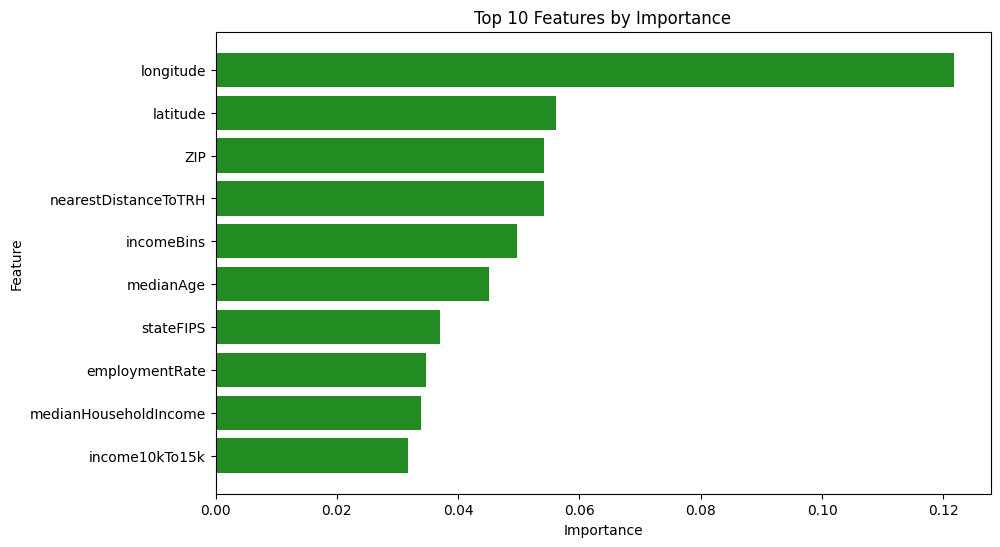

In [40]:
#plotting a bar chart to analyze feature importance.
importanceDf = pd.DataFrame({'Feature': x.columns, 'Importance': tunedGradBoost.feature_importances_}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importanceDf["Feature"].head(10), importanceDf["Importance"].head(10), color="#228B22")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features by Importance")
plt.gca().invert_yaxis()
plt.show()

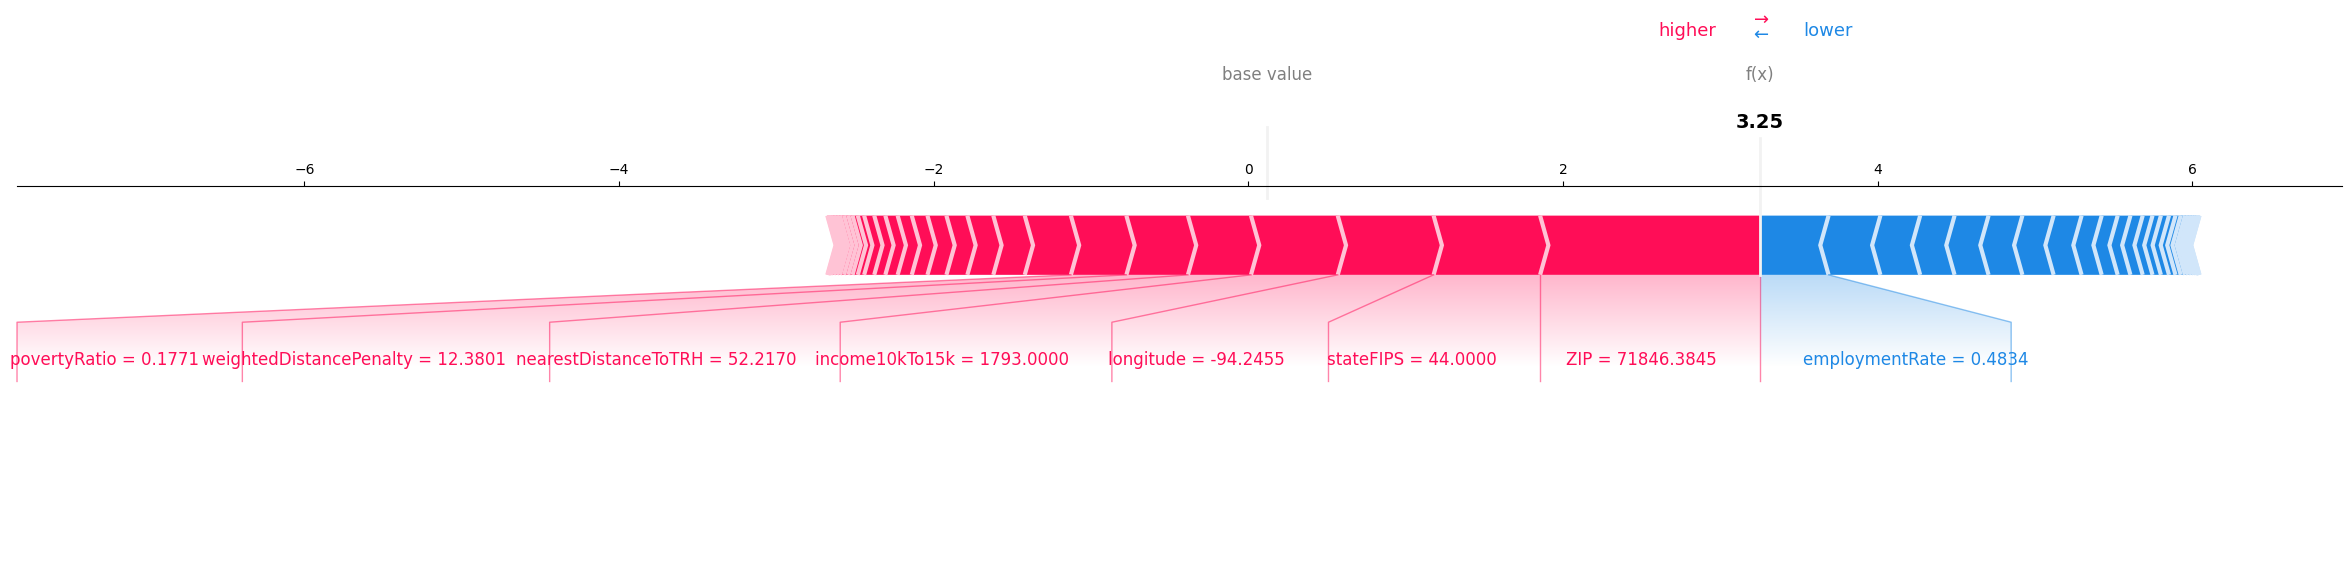

In [41]:
#performing SHAP analysis to understand which features contributed most to the predictions and creating the force plot.
explainer = shap.TreeExplainer(tunedGradBoost)
shapValues = explainer.shap_values(xTest)
#formatting the model features for maximum readability.
formatValues = xTest.iloc[0, :].apply(lambda x: f"{x:.4f}")
shap.force_plot(explainer.expected_value, shapValues[0], pd.Series(formatValues, index=xTest.columns), matplotlib=True, figsize=(30, 5))

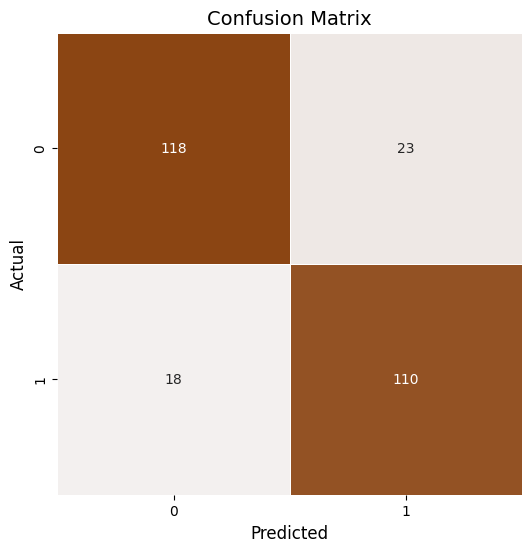

In [42]:
#plotting a confusion matrix to visualize predictions.
confMat = confusion_matrix(yTest, yPredTunedGradBoost)
plt.figure(figsize=(6, 6))
sns.heatmap(confMat, annot=True, fmt='d', cmap=sns.light_palette("#8B4513", as_cmap=True), cbar=False, linewidths=0.5)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()

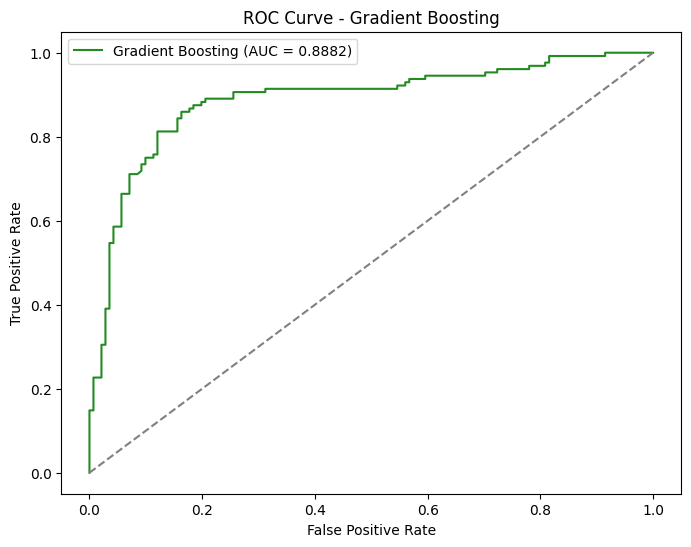

In [43]:
#plotting an ROC curve to show the model's ability to classify negative and positive outcomes.
#calculating the area under curve score for the gradient boosting model.
fpr, tpr, _ = roc_curve(yTest, tunedGradBoost.predict_proba(xTest)[:, 1])
aucScore = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="#228B22", label=f"Gradient Boosting (AUC = {aucScore:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend()
plt.show()

In [44]:
#loading data
df1 = pd.read_csv("trhCensusDf_updated.csv")
df2 = pd.read_csv("updatedLocationResearch.csv")

In [45]:
#dropping 'state' and 'unmarriedPartners' and renaming the zip code column.
df2 = df2.drop(columns=['state', 'unmarriedPartners', 'address', 'placeName', 'geometry'], errors='ignore')
df2 = df2.rename(columns={'zip': 'ZIP'})

In [46]:
#correcting latitude and longitude for arvada and barnwell
df2.loc[df2['city'].str.upper() == 'ARVADA', ['latitude', 'longitude']] = [39.8028, -105.0875]
df2.loc[df2['city'].str.upper() == 'BARNWELL', ['latitude', 'longitude']] = [33.2443, -81.3581]

In [48]:
#converting latitude and longitude to numeric values
df1['latitude'] = pd.to_numeric(df1['latitude'], errors='coerce')
df1['longitude'] = pd.to_numeric(df1['longitude'], errors='coerce')
df2['latitude'] = pd.to_numeric(df2['latitude'], errors='coerce')
df2['longitude'] = pd.to_numeric(df2['longitude'], errors='coerce')

In [49]:
#defining a function to calculate the distance to the nearest TRH restaurant and calculating the distances
def calculateNearestDistance(lat, lon, trhLocations):
    if pd.isnull(lat) or pd.isnull(lon):
        return None
    distances = [fabs(geodesic((lat, lon), (trhLat, trhLon)).miles)
        for trhLat, trhLon in zip(trhLocations['latitude'], trhLocations['longitude'])]
    return min(distances) if distances else None
df2['nearestDistanceToTRH'] = df2.apply(lambda row: calculateNearestDistance(row['latitude'], row['longitude'], df1), axis=1)

In [50]:
#conducting feature engineering for df2 the same as training data for the fine tuned gb model
df2['incomeRentRatio'] = df2['medianHouseholdIncome'] / (df2['medianGrossRent'] + 1e-6)
df2['povertyRatio'] = df2['populationBelowPoverty'] / (df2['totalPopulation'] + 1e-6)
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df2['incomeBins'] = binner.fit_transform(df2[['medianHouseholdIncome']])
df2['employmentRate'] = df2['employedPopulation'] / (df2['totalPopulation'] + 1e-6)
df2['distancePenalty'] = df2['nearestDistanceToTRH'].apply(lambda dist: 1 if 10 <= dist <= 50 else (10 / dist if dist > 50 else dist / 10))
df2['weightedDistancePenalty'] = df2['distancePenalty'] * distanceWeight
df2['populationPenalty'] = 1 / (df2['totalPopulation'] + 1e-6)
df2['weightedPopulationPenalty'] = df2['populationPenalty'] * popWeight

In [51]:
#creating a dataset to house 'city' and dropping 'city' and 'placeName' for preprocessing
df2CityColumn = df2[['city']].copy()
df2 = df2.drop(columns=['placeName', 'city'], errors='ignore')

In [52]:
#encoding categorical columns in df2 and reordering to match columns in xTrain
df2 = pd.get_dummies(df2, drop_first=True)
df2 = df2[xTrain.columns]

In [53]:
#predicting the probability of success using the tuned gb model and adding labels based on predictions
df2['successProbability'] = tunedGradBoost.predict_proba(df2)[:, 1]
df2['adjustedSuccessProbability'] = (df2['successProbability'] - df2['weightedDistancePenalty'] - df2['weightedPopulationPenalty']).clip(0, 1)
df2['predictedLabel'] = np.where(df2['successProbability'] > 0.5, "Likely Successful", "Unlikely Successful")

In [54]:
#reattaching the city name to df2 and saving predictions.
df2[['city']] = df2CityColumn
df2.to_csv("predictedTRHLocations.csv", index=False)

In [55]:
#adding columns relevant to one dataset to the other dataset, and filling them with 0
df2["successMetric"] = 0
df2["success"] = 0
df2["rating"] = 0
df2["totalUserRatings"] = 0
df1["successProbability"] = 0
df1["predictedLabel"] = 0
#creating a new column to decipher between existing and potential locations
df2["existingLocation"] = 0
df1["existingLocation"] = 1

In [56]:
#aligning columns in df1 and df2 as a best practice before concatenation
commonColumns = [col for col in df1.columns if col in df2.columns]
df1 = df1[commonColumns]
df2 = df2[commonColumns]

In [57]:
#concatenating the existing and predicting datasets and saving them to a csv file for use in Tableau
combinedTRHLocations = pd.concat([df1, df2], ignore_index=True)
combinedTRHLocations.to_csv("combinedTRHLocations.csv", index=False)

In [58]:
df3 = pd.read_csv("combinedTRHLocations.csv")

In [59]:
#drop rows with negative value in medianHouseholdIncome and fill negative values with localized average values.
df3 = df3[df3['medianHouseholdIncome'] >= 0]
df3['ZIP3'] = df3['ZIP'].astype(str).str[:3]
negativeValueColumns = ['medianGrossRent', 'medianHomeValue', 'medianMonthlyHousingCosts']
for column in negativeValueColumns:
    groupAverages = df3.groupby('ZIP3')[column].transform('mean')
    df3[column] = np.where(df3[column] < 0, groupAverages, df3[column])

In [60]:
#dropping columns with many negative values and saving as the csv is finalized for analysis
df3.to_csv('finalizedTRH.csv', index=False)